In [147]:
#mount gdrive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [148]:
from pandas.io.pytables import DataCol
bus_trip_all_points_path = '/content/drive/MyDrive/DSE_Project/dataOut/bus_trip_all_points.csv'
# import bus trips
bus_trips_path = "/content/drive/MyDrive/DSE_Project/dataOut/bus_trips.csv"

dataOut_path = "/content/drive/MyDrive/DSE_Project/dataOut"

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler



In [150]:
data = pd.read_csv(bus_trip_all_points_path)
# import bus trips
bus_trips = pd.read_csv(bus_trips_path)

In [151]:
# print a list of unique trip ids
trip_ids = data['trip_id'].unique()

trip_ids = [int(x) for x in trip_ids]

## Detect and remove Anomaly Trips

1.   if above 10% of GPS points above a certain distance from the reference GPS points then it is an anomaly
2.   We will remove the anomaly trips from the data.



In [152]:

from sklearn.metrics.pairwise import haversine_distances
from math import radians

# Define a function to calculate Haversine distance between two points
# harvsersine formula gives distance between two gps points

def haversine_distance(coord1, coord2):
    #convert deg to rad for trig functions

    coord1 = [radians(x) for x in coord1]
    coord2 = [radians(x) for x in coord2]
    dist = haversine_distances([coord1, coord2])
    return dist[0][1] * 6371000.0  # Multiply by Earth radius to get distance in meters


In [156]:
def detect_anomalies(data, trip_id_column, longitude_column, latitude_column, reference_data, reference_trip_id, threshold_distance_meters=200, anomaly_percentage=0.1):
    reference_locations = reference_data.loc[reference_data[trip_id_column] == reference_trip_id, [latitude_column, longitude_column]].values

    anomalies = []
    for trip_id, trip_data in data.groupby(trip_id_column):
        gps_locations = trip_data[[latitude_column, longitude_column]].values

        # Vectorized Haversine distance calculation for all points in a trip against all points in the reference
        distances = np.array([haversine_distance((loc[0], loc[1]), (ref_loc[0], ref_loc[1])) for loc in gps_locations for ref_loc in reference_locations])
        distances = distances.reshape(len(gps_locations), len(reference_locations))

        # Minimal distance from each point in the trip to any point in the reference trip
        min_distances = distances.min(axis=1)

        # Count of anomalies based on the threshold
        anomaly_count = np.sum(min_distances > threshold_distance_meters)

        # Check if anomaly count exceeds the allowed percentage
        if anomaly_count / len(gps_locations) >= anomaly_percentage:
            anomalies.append((trip_id, anomaly_count))  # Store tuple with trip_id and anomaly_count

    return anomalies


In [157]:

# Columns for trip ID, longitude, and latitude in your DataFrame
trip_id_column = 'trip_id'
longitude_column = 'longitude'
latitude_column = 'latitude'
reference_threshold_distance_meters = 200
anomaly_percentage = 0.1
# Reference data for correct GPS locations (longitude and latitude values)
reference_trip_id = 4  # Specify the trip ID for which to get the reference data
reference_data = data[data[trip_id_column] == reference_trip_id]  # Filter reference data



In [158]:
# detect anomalies in GPS data
# default threshold_distance_meters = 200
anomaly_trip_ids = detect_anomalies(data, trip_id_column, longitude_column, latitude_column, reference_data, reference_trip_id)
data = data[~data[trip_id_column].isin(anomaly_trip_ids)]


In [159]:

# save anomalous trips ids to csv
anomaly_trip_ids_df = pd.DataFrame(anomaly_trip_ids)
anomaly_trip_ids_df.to_csv(dataOut_path + '/anomaly_trip_ids.csv', index=False)



In [ ]:

# # Split data into chunks for parallel processing
# chunk_size = 10  # Number of trip IDs in each chunk
# trip_ids = data[trip_id_column].unique()
# chunks = [trip_ids[i:i + chunk_size] for i in range(0, len(trip_ids), chunk_size)]

# # Reference data for correct GPS locations (longitude and latitude values)
# reference_trip_id = 4  # Specify the trip ID for which to get the reference data
# reference_data = data[data[trip_id_column] == reference_trip_id]  # Filter reference data


# threshold_distance_meters=200

# # Create a ThreadPoolExecutor for parallel processing
# with ThreadPoolExecutor(max_workers=16) as executor:
#     futures = []
#     for chunk_trip_ids in chunks:
#         chunk_data = data[data[trip_id_column].isin(chunk_trip_ids)]
#         for trip_id in chunk_trip_ids:
#             chunk_trip_data = chunk_data[chunk_data[trip_id_column] == trip_id]
#             future = executor.submit(process_trip, chunk_trip_data, reference_data, threshold_distance_meters)
#             futures.append(future)

#     anomaly_trip_ids = []
#     for future in futures:
#         result = future.result()
#         if result:
#             anomaly_trip_ids.append(result)

# # Filter anomaly trips and save to CSV
# cleaned_data = data[~data[trip_id_column].isin(anomaly_trip_ids)]

# print(f"Anomaly trips detected and removed: {anomaly_trip_ids}")

# # Save anomaly trip IDs to CSV file
# anomaly_trip_ids_df = pd.DataFrame(anomaly_trip_ids, columns=[trip_id_column])
# anomaly_trip_ids_df.to_csv('../DataOut/anomaly_trip_ids.csv', index=False)


In [160]:
def filter_trips(data, min_gps_points=50):
    # Ensure trip_id is the index
    data = data.set_index('trip_id')

    # Calculate the count of GPS points for each trip
    gps_point_counts = data.groupby('trip_id').size()

    # Print the average number of GPS points per trip
    avg_gps_points = gps_point_counts.mean()
    print(f"Average GPS points per trip: {avg_gps_points:.2f}")

    # Find and print trip IDs with less than the minimum required GPS points
    low_gps_trips = gps_point_counts[gps_point_counts < min_gps_points].index
    print(f"Trip IDs with less than {min_gps_points} GPS points: {low_gps_trips.tolist()}")

    # Filter and return data with trips having at least the minimum required GPS points
    valid_trip_ids = gps_point_counts[gps_point_counts >= min_gps_points].index

    # Filter the data without creating a copy
    filtered_data = data.loc[valid_trip_ids]
    filtered_data.reset_index(inplace=True)
    return filtered_data


In [161]:
data = filter_trips(data)

Average GPS points per trip: 9.62
Trip IDs with less than 50 GPS points: [59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 161.0, 162.0, 163.0, 164.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 171.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 179.0, 180.0, 181.0, 182.0, 183.0, 184.0, 185.0, 186.0, 187.0, 188.0, 189.0, 190.0, 191.0, 192.0, 193.0, 194.0, 195.0, 196.0, 1

In [162]:
#count number of trips which is index
data['trip_id'].nunique()

58

## feature Eng

### Add Acceleration

In [163]:
import pandas as pd
import numpy as np

def add_acceleration(data):
    # Convert 'devicetime' to datetime if not already
    if data['devicetime'].dtype != 'datetime64[ns]':
        data['devicetime'] = pd.to_datetime(data['devicetime'])

    # Ensure 'trip_id' is of type 'category'
    data['trip_id'] = data['trip_id'].astype('category')

    # Calculate time_diff and speed_diff using single groupby and diff
    data[['time_diff', 'speed_diff']] = data.groupby('trip_id')[['devicetime', 'speed']].diff()

    # Ensure 'time_diff' is in seconds
    data['time_diff'] = data['time_diff'].dt.total_seconds()
    data = data[np.isfinite(data['time_diff']) & (data['time_diff'] > 0.001)]

    # Calculate acceleration and handle infinite values and NaN
    with np.errstate(divide='ignore', invalid='ignore'):
        data['acceleration'] = data['speed_diff'] / data['time_diff']
        data['acceleration'].replace([np.inf, -np.inf], np.nan, inplace=True)
        data['acceleration'].fillna(0, inplace=True)
    data.drop(columns=['time_diff', 'speed_diff'])
    return data


In [164]:
data = add_acceleration(data)


<ipython-input-163-a9054038644a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['acceleration'] = data['speed_diff'] / data['time_diff']
<ipython-input-163-a9054038644a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['acceleration'].replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-163-a9054038644a>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  d

In [ ]:
data.head()

In [165]:
# save to csv
data.to_csv( dataOut_path + '/bus_trip_all_points_with_acceleration.csv', index=False)

In [166]:
data.reset_index(inplace=True)
data.index

RangeIndex(start=0, stop=13996, step=1)

### Radial Acc

In [167]:
from math import cos, radians, sqrt
from pyproj import Proj, Transformer
from tqdm import tqdm  # Import tqdm



def lat_lon_to_utm(lat, lon):
    # Create a UTM projection for the appropriate UTM zone (Zone 44N for Sri Lanka)
    utm_zone = 44
    utm_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')

    # Convert latitude and longitude to UTM coordinates
    utm_easting, utm_northing = utm_proj(lon, lat)
    return utm_easting, utm_northing
# Calculate radius of curvature using OpenStreetMap API

def calculate_radius_of_curvature(x1, y1, x2, y2, x3,y3):
    x12 = x1 - x2;
    x13 = x1 - x3;

    y12 = y1 - y2;
    y13 = y1 - y3;

    y31 = y3 - y1;
    y21 = y2 - y1;

    x31 = x3 - x1;
    x21 = x2 - x1;

    # x1^2 - x3^2
    sx13 = pow(x1, 2) - pow(x3, 2);

    # y1^2 - y3^2
    sy13 = pow(y1, 2) - pow(y3, 2);

    sx21 = pow(x2, 2) - pow(x1, 2);
    sy21 = pow(y2, 2) - pow(y1, 2);

    denominator = 2 * ((y31) * (x12) - (y21) * (x13))

    # Avoid division by zero
    if denominator == 0:
        return 0  # Or some other value you want to use

    f = (((sx13) * (x12) + (sy13) *
          (x12) + (sx21) * (x13) +
          (sy21) * (x13)) // denominator)

    g = (((sx13) * (y12) + (sy13) * (y12) +
          (sx21) * (y13) + (sy21) * (y13)) //
          (2 * ((x31) * (y12) - (x21) * (y13))));

    c = (-pow(x1, 2) - pow(y1, 2) -
         2 * g * x1 - 2 * f * y1);

    # eqn of circle be x^2 + y^2 + 2*g*x + 2*f*y + c = 0
    # where centre is (h = -g, k = -f) and
    # radius r as r^2 = h^2 + k^2 - c
    h = -g;
    k = -f;
    sqr_of_r = h * h + k * k - c;

    # r is the radius
    r = round(sqrt(sqr_of_r), 5);
    return r

# Calculate radial acceleration based on speed and radius of curvature
def calculate_radial_acceleration(speed, radius_of_curvature):
    if radius_of_curvature != 0:
        radial_acceleration = speed**2 / radius_of_curvature
    else:
        radial_acceleration = 0
    return radial_acceleration


# Define the function to calculate radial acceleration for a given trip
def calculate_radial_acceleration_for_trip(trip_df):
    window_size = 1

    # Create a copy of the trip DataFrame to avoid modifying the original
    trip_df = trip_df.copy()

    for i in tqdm(range(window_size, len(trip_df) - window_size), position=0, leave=True):
        lat1, lon1 = trip_df.iloc[i - window_size]["latitude"], trip_df.iloc[i - window_size]["longitude"]
        lat2, lon2 = trip_df.iloc[i]["latitude"], trip_df.iloc[i]["longitude"]
        lat3, lon3 = trip_df.iloc[i + window_size]["latitude"], trip_df.iloc[i + window_size]["longitude"]

        x1, y1 = lat_lon_to_utm(lat1, lon1)
        x2, y2 = lat_lon_to_utm(lat2, lon2)
        x3, y3 = lat_lon_to_utm(lat3, lon3)

        radius_of_curvature = calculate_radius_of_curvature(x1, y1, x2, y2, x3, y3)
        speed = trip_df.iloc[i]["speed"]

        radial_acceleration = calculate_radial_acceleration(speed, radius_of_curvature)
        trip_df.at[i, "radial_acceleration"] = radial_acceleration

    return trip_df


In [168]:

# Create a dictionary to store DataFrames for each trip ID
trip_dataframes = {}
window_size = 1  # Number of rows to use for calculating radius of curvature
trips = data['trip_id'].unique()

# Use tqdm to create a single progress bar for the entire process
with tqdm(total=len(trips), position=0, leave=True) as pbar:
    # Iterate over trip IDs to calculate radial acceleration for each trip's DataFrame
    for trip_id in trips:
        trip_df = data[data["trip_id"] == trip_id].copy()  # Get DataFrame for the current trip

        # Reset the index of trip_df only once
        trip_df.reset_index(drop=True, inplace=True)

        for i in range(window_size, len(trip_df) - window_size):
            lat1, lon1 = trip_df.iloc[i - window_size]["latitude"], trip_df.iloc[i - window_size]["longitude"]
            lat2, lon2 = trip_df.iloc[i]["latitude"], trip_df.iloc[i]["longitude"]
            lat3, lon3 = trip_df.iloc[i + window_size]["latitude"], trip_df.iloc[i + window_size]["longitude"]

            x1, y1 = lat_lon_to_utm(lat1, lon1)
            x2, y2 = lat_lon_to_utm(lat2, lon2)
            x3, y3 = lat_lon_to_utm(lat3, lon3)

            radius_of_curvature = calculate_radius_of_curvature(x1, y1, x2, y2, x3, y3)
            speed = trip_df.iloc[i]["speed"]

            radial_acceleration = calculate_radial_acceleration(speed, radius_of_curvature)
            trip_df.at[i, "radial_acceleration"] = radial_acceleration

        trip_dataframes[trip_id] = trip_df  # Store the calculated DataFrame for the trip
        pbar.update(1)  # Update the progress bar


100%|██████████| 58/58 [00:51<00:00,  1.13it/s]


In [169]:

# Concatenate all trip-specific dataframes into one
concatenated_df = pd.concat(trip_dataframes.values(), ignore_index=True)

# Iterate through rows and assign radial acceleration values to the original dataframe
for index, row in concatenated_df.iterrows():
    data.loc[data['id'] == row['id'], 'radial_acceleration'] = row['radial_acceleration']

print(data)


       index trip_id          id  deviceid          devicetime  latitude  \
0          1     1.0  1227897149       116 2022-07-01 06:52:36  7.298092   
1          2     1.0  1227897151       116 2022-07-01 06:52:51  7.297458   
2          3     1.0  1227897154       116 2022-07-01 06:52:59  7.297447   
3          4     1.0  1227897158       116 2022-07-01 06:53:14  7.297448   
4          5     1.0  1227898089       116 2022-07-01 06:53:29  7.297435   
...      ...     ...         ...       ...                 ...       ...   
13991  14308    58.0  1282614502       117 2022-07-28 17:20:37  7.290630   
13992  14309    58.0  1282617695       117 2022-07-28 17:20:52  7.291055   
13993  14310    58.0  1282617694       117 2022-07-28 17:21:07  7.291298   
13994  14311    58.0  1282617693       117 2022-07-28 17:21:22  7.291448   
13995  14312    58.0  1282617691       117 2022-07-28 17:21:32  7.291710   

       longitude     speed        date      time  \
0      80.733112  17.27860  2022-07

In [ ]:
data.columns

In [ ]:
## maybe faster
# #from lattitude , longitude to universal transverse mercantory
# def lat_lon_to_utm(lat, lon, utm_proj):
#     utm_easting, utm_northing = utm_proj(lon, lat)
#     return utm_easting, utm_northing


# # Calculate radial acceleration based on speed and radius of curvature
# def calculate_radial_acceleration(speed, radius_of_curvature):
#     if radius_of_curvature != 0:
#         radial_acceleration = speed**2 / radius_of_curvature
#     else:
#         radial_acceleration = 0
#     return radial_acceleration


# def calculate_radial_acceleration_for_trip(trip_df, utm_proj):
#     trip_df = trip_df.copy()
#     trip_df[['utm_easting', 'utm_northing']] = np.vectorize(lat_lon_to_utm)(
#         trip_df['latitude'], trip_df['longitude'], utm_proj)

#     window_size = 1
#     for i in tqdm(range(window_size, len(trip_df) - window_size), position=0, leave=True):
#         x1, y1 = trip_df.loc[i - window_size, ['utm_easting', 'utm_northing']]
#         x2, y2 = trip_df.loc[i, ['utm_easting', 'utm_northing']]
#         x3, y3 = trip_df.loc[i + window_size, ['utm_easting', 'utm_northing']]

#         radius_of_curvature = calculate_radius_of_curvature(x1, y1, x2, y2, x3, y3)
#         speed = trip_df.loc[i, 'speed']

#         radial_acceleration = calculate_radial_acceleration(speed, radius_of_curvature)
#         trip_df.loc[i, 'radial_acceleration'] = radial_acceleration

#     return trip_df

# # Create a UTM projection for the appropriate UTM zone (Zone 44N for Sri Lanka)
# utm_zone = 44
# utm_proj = Proj(proj='utm', zone=utm_zone, ellps='WGS84')

# # Assuming 'data' DataFrame is defined and includes 'latitude', 'longitude', 'speed', and 'trip_id'
# concatenated_df = pd.concat(
#     [calculate_radial_acceleration_for_trip(data[data['trip_id'] == trip_id], utm_proj)
#      for trip_id in tqdm(data['trip_id'].unique())],
#     ignore_index=True
# )


In [170]:
# fill Nan values with 0
data['radial_acceleration'].fillna(0, inplace=True)

In [ ]:
# data.to_csv(dataOut_path + '/bus_trip_all_points_with_acceleration_and_radial_acceleration.csv', index=False)

In [ ]:
# data = pd.read_csv('dataOut_path + '/bus_trip_all_points_with_acceleration_and_radial_acceleration.csv')

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert 'devicetime' column to datetime
data['devicetime'] = pd.to_datetime(data['devicetime'])

# Draw a line graph of radial acceleration against time for a single trip
def draw_radial_acceleration_graph(trip_id):
    trip_df = data[data["trip_id"] == trip_id]
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.plot(trip_df["devicetime"], trip_df["radial_acceleration"])
    plt.xlabel("Time")
    plt.ylabel("radial_acceleration")
    plt.title("Trip " + str(trip_id))
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout for better formatting
    plt.show()

draw_radial_acceleration_graph(4)
draw_radial_acceleration_graph(2)
draw_radial_acceleration_graph(20)


### Distance from start

#### Cumalative addition of distance

In [171]:
# data_copy = data

In [ ]:
data.nunique()

In [172]:
import pandas as pd
import numpy as np

# Convert the 'devicetime' column to pandas Timestamp if it's not already
data['devicetime'] = pd.to_datetime(data['devicetime'])

# Vectorized Haversine distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth's radius in meters
    phi_1 = np.radians(lat1)
    phi_2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)

    a = np.sin(delta_phi / 2.0)**2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    meters = R * c  # Distance in meters
    return meters

# Compute the distance and cumulative distance
data['distance'] = haversine_distance(
    data['latitude'], data['longitude'],
    data['latitude'].shift(), data['longitude'].shift()
)
# Ensuring that the first row of each trip does not use the last row of the previous trip
data.loc[data['trip_id'] != data['trip_id'].shift(), 'distance'] = np.nan
# Calculate cumulative distance
data['cumulative_distance'] = data.groupby('trip_id')['distance'].cumsum()

print(data['cumulative_distance'])


0                 NaN
1          117.102057
2          157.931665
3          158.694431
4          184.293012
             ...     
13991    15355.725395
13992    15444.999576
13993    15544.336823
13994    15664.618294
13995    15739.280888
Name: cumulative_distance, Length: 13996, dtype: float64


In [ ]:
#count nan
data

In [ ]:
# drop distance column and rename cumulative_distance to distance from start
data.drop(['distance'], axis=1, inplace=True)
data.rename(columns={'cumulative_distance': 'distance_from_start'}, inplace=True)


In [175]:
# fill nan with 0
data['distance_from_start'].fillna(0, inplace=True)

In [179]:
# save as csv file
data.to_csv(dataOut_path + '/bus_trip_all_points_with_acceleration_and_radial_acceleration_and_distance.csv', index=False)

In [180]:
# read csv
data = pd.read_csv(dataOut_path + '/bus_trip_all_points_with_acceleration_and_radial_acceleration_and_distance.csv')

In [181]:
data[data['direction'] == 1]['trip_id'].nunique()

28

## Get Accelaration and Breaks

In [ ]:
import pandas as pd
import numpy as np

# Assuming you have a DataFrame named 'data' with columns: 'acceleration', 'devicetime', and 'trip_id'
# Convert the 'devicetime' column to pandas Timestamp if it's not already
data['devicetime'] = pd.to_datetime(data['devicetime'])

# Calculate time difference between consecutive rows within the same trip
data['time_diff'] = data.groupby('trip_id')['devicetime'].diff()

# Calculate change in acceleration between consecutive rows within the same trip
data['acc_diff'] = data.groupby('trip_id')['acceleration'].diff()

# Filter out rows with time differences close to zero
# data = data[data['time_diff'].dt.total_seconds() > 0.001]  # Adjust the threshold as needed

# Calculate acceleration by dividing acceleration difference by time difference (avoiding division by zero)
data['acceleration_der'] = data['acc_diff'] / data['time_diff'].dt.total_seconds()

# Handle the case where time difference is zero or very close to zero, set acceleration_der to 0
data['acceleration_der'].replace([np.inf, -np.inf], np.nan, inplace=True)
data['acceleration_der'].fillna(0, inplace=True)

data.head()


In [183]:
# save as csv file
data.to_csv(dataOut_path + '/bus_trip_all_points_with_acceleration_and_radial_acceleration_and_distance_and_accDiff.csv', index=False)

In [184]:
data[data['direction'] == 1]['trip_id'].nunique()

28

In [185]:
data[data['trip_id'] == 1]

,index,trip_id,id,deviceid,devicetime,latitude,longitude,speed,date,time,geometry,bus_stop,direction,time_diff,speed_diff,acceleration,radial_acceleration,distance_from_start,acc_diff,acceleration_der
0,1,1.0,1227897149,116,2022-07-01 06:52:36,7.298092,80.733112,17.2786,2022-07-01,06:52:36,POINT (195516.1533184196 232873.58587809888),NaN,2,NaT,3.2397,0.215980,0.000000,0.000000,NaN,0.000000
1,2,1.0,1227897151,116,2022-07-01 06:52:51,7.297458,80.732263,16.7387,2022-07-01,06:52:51,POINT (195422.48329649286 232803.5622761236),NaN,2,0 days 00:00:15,-0.5399,-0.035993,2.109097,117.102057,-0.251973,-0.016798
2,3,1.0,1227897154,116,2022-07-01 06:52:59,7.297447,80.731893,0.0000,2022-07-01,06:52:59,POINT (195381.63007485462 232802.2720537569),NaN,2,0 days 00:00:08,-16.7387,-2.092338,0.000000,157.931665,-2.056344,-0.257043
3,4,1.0,1227897158,116,2022-07-01 06:53:14,7.297448,80.731900,0.0000,2022-07-01,06:53:14,POINT (195382.36986395245 232802.45997819622),NaN,2,0 days 00:00:15,0.0000,0.000000,0.000000,158.694431,2.092338,0.139489
4,5,1.0,1227898089,116,2022-07-01 06:53:29,7.297435,80.731668,10.2592,2022-07-01,06:53:29,POINT (195356.7868534024 232800.98044114),NaN,2,0 days 00:00:15,10.2592,0.683947,0.509078,184.293012,0.683947,0.045596
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,188,1.0,1228080631,116,2022-07-01 07:37:18,7.290455,80.639247,16.1987,2022-07-01,07:37:18,POINT (185151.91834696376 232031.06622951088),213,2,0 days 00:00:15,-1.0799,-0.071993,0.615134,15115.580311,-0.107987,-0.007199
188,189,1.0,1228080632,116,2022-07-01 07:37:33,7.290682,80.638287,18.3585,2022-07-01,07:37:33,POINT (185045.9266024676 232056.166475904),NaN,2,0 days 00:00:15,2.1598,0.143987,0.835895,15224.423702,0.215980,0.014399
189,190,1.0,1228080634,116,2022-07-01 07:37:48,7.291270,80.637278,12.9590,2022-07-01,07:37:48,POINT (184934.61378975454 232121.25514613063),NaN,2,0 days 00:00:15,-5.3995,-0.359967,0.469679,15353.447751,-0.503953,-0.033597
190,191,1.0,1228080635,116,2022-07-01 07:38:03,7.291432,80.635720,25.3780,2022-07-01,07:38:03,POINT (184762.55855552605 232139.18785771224),NaN,2,0 days 00:00:15,12.4190,0.827933,2.703667,15526.259558,1.187900,0.079193


In [186]:
# Draw a line graph of radial acceleration against time for a single trip
def drawAgainst(data,trip_id,columnx,columny):
    trip_df = data[data["trip_id"] == trip_id]
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed
    plt.plot(trip_df[f"{columnx}"], trip_df[f"{columny}"])
    plt.xlabel(f"{columnx}")
    plt.ylabel(f"{columny}")
    plt.title("Trip " + str(trip_id))
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
    plt.tight_layout()  # Adjust layout for better formatting
    plt.show()


In [187]:
# get the number of unique trip ids
unique_trip_ids = data['trip_id'].unique()
len(unique_trip_ids)

58

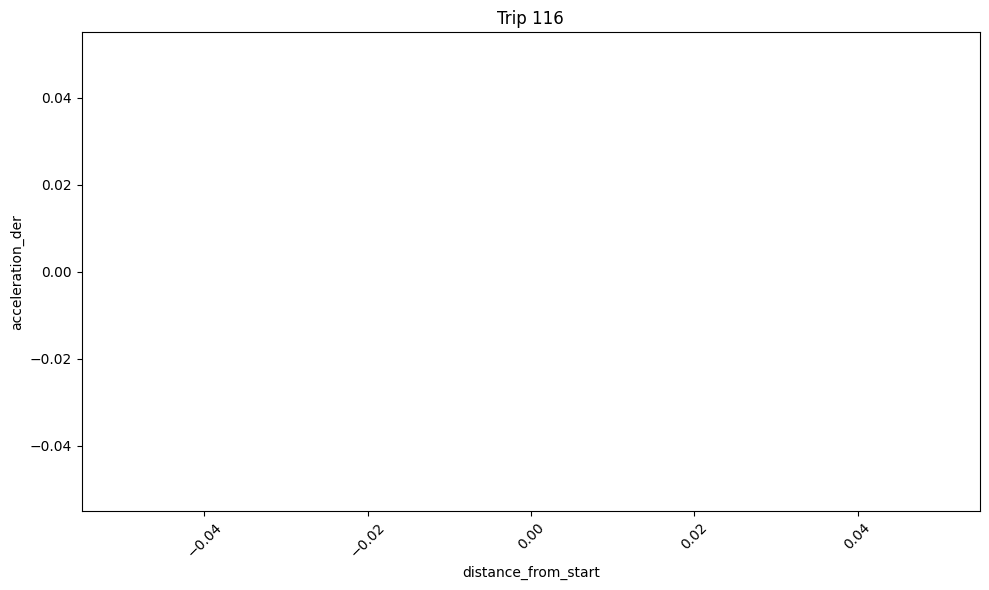

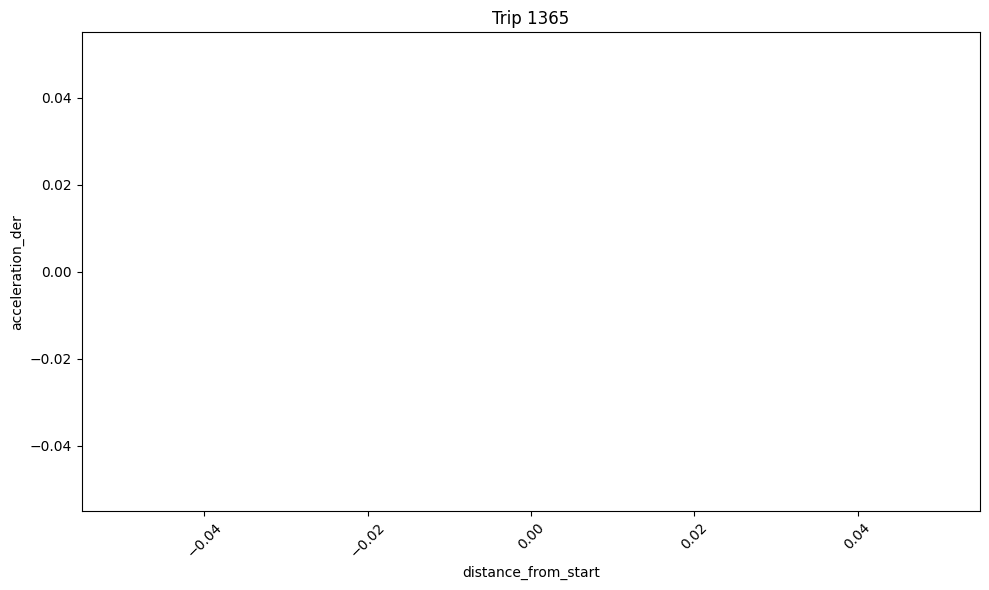

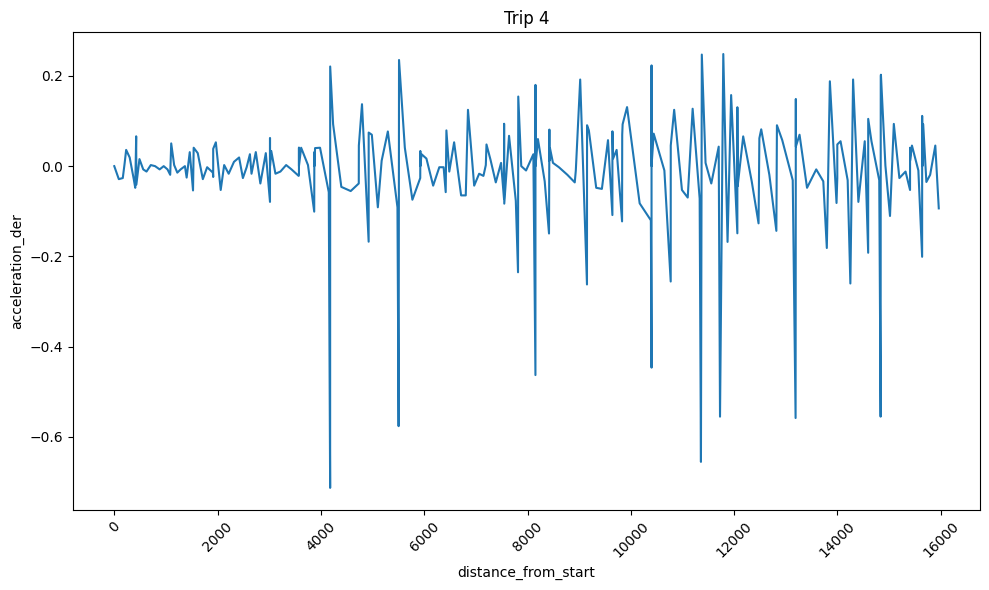

In [188]:
drawAgainst(data,116,'distance_from_start','acceleration_der')
drawAgainst(data,1365,'distance_from_start','acceleration_der')
drawAgainst(data,4,'distance_from_start','acceleration_der')

## Check whether the time or distance is better

In [189]:
# data with trip id 5672
data[data['trip_id'] == 5672]

,index,trip_id,id,deviceid,devicetime,latitude,longitude,speed,date,time,geometry,bus_stop,direction,time_diff,speed_diff,acceleration,radial_acceleration,distance_from_start,acc_diff,acceleration_der
